In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import RoadSatelliteModule
from system import SemanticSegmentationSystem

from models import *

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
from torchinfo import summary

import regex as re

In [3]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# 1. Preparation

In [4]:
batch_size = 8
num_workers = 8

In [5]:
pl.seed_everything(7, workers=True)

Global seed set to 7


7

## 1.1 DataModule

In [6]:
road_data = RoadSatelliteModule(num_workers=num_workers, batch_size=batch_size)

In [7]:
%%time
X, y = next(iter(road_data.val_dataloader()))

CPU times: user 2.14 s, sys: 1.62 s, total: 3.76 s
Wall time: 4.61 s


In [8]:
imgs, masks = next(iter(road_data.test_dataloader()))

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


## 1.2 Inspect Data

In [9]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

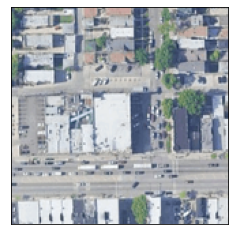

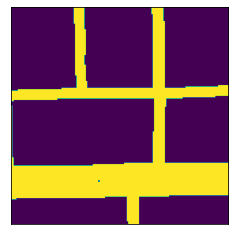

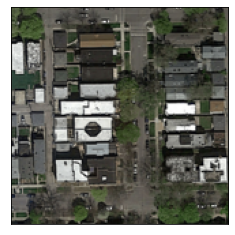

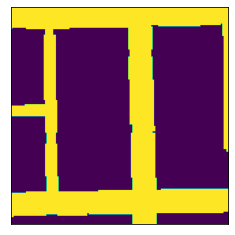

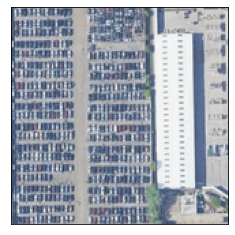

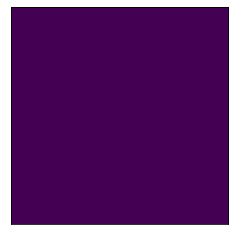

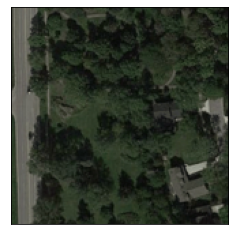

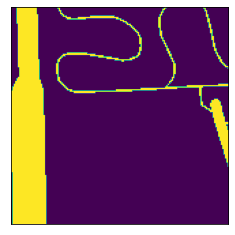

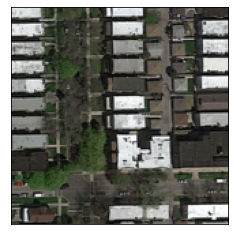

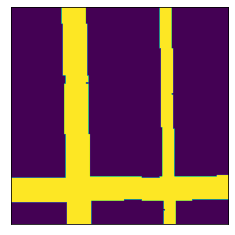

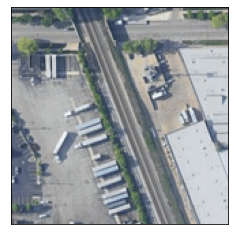

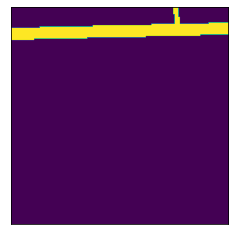

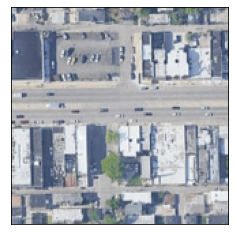

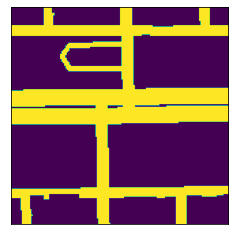

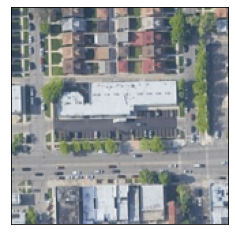

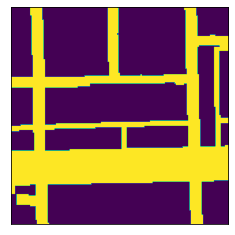

In [10]:
for u, v in zip(X, y):
    show_image(u)
    show_image(v)

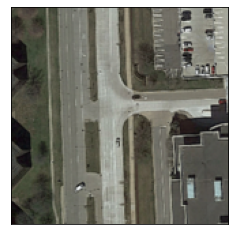

In [11]:
show_image(imgs[0][0])

# 2. Define Model / System

In [12]:
load_from_checkpoint = True

### Nested UNet

In [13]:
model1 = NestedUNet(1, 3)
model1_name = str(model1).partition('(')[0]

In [14]:
system1 = SemanticSegmentationSystem(model1, road_data, n_closing=0)

In [15]:
if load_from_checkpoint:
    nested_system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model1_name + "_data"}/{model1_name + "_data"}.ckpt', model=model1, datamodule=road_data)

### UNet Spatial Dilated

In [16]:
model2 = UNetSpatialDilated(1, 3)
model2_name = str(model2).partition('(')[0]

In [17]:
system2 = SemanticSegmentationSystem(model2, road_data, n_closing=0)

In [18]:
if load_from_checkpoint:
    unet_system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model2_name + "_data"}/{model2_name + "_data"}.ckpt', model=model2, datamodule=road_data)

### UNet 3 Plus Spatial Dilated

In [19]:
model3 = UNet_3Plus_Spatial_Dilated(3, 1)
model3_name = str(model3).partition('(')[0]

In [20]:
system3 = SemanticSegmentationSystem(model3, road_data, n_closing=0)

In [21]:
if load_from_checkpoint:
    three_system = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model3_name + "_data"}/{model3_name + "_data"}.ckpt', model=model3, datamodule=road_data)

# 4. Training

In [22]:
if torch.cuda.is_available():
    gpu_count = -1
    gpu_auto_select = True
else:
    gpu_count = 0
    gpu_auto_select = False

In [23]:
checkpoint1_callback = ModelCheckpoint(
    monitor='validation_f1',
    dirpath='./lightning_logs',
    filename=model1_name,
    save_top_k=1,
    verbose=2,
    mode='max'
)

checkpoint2_callback = ModelCheckpoint(
    monitor='validation_f1',
    dirpath='./lightning_logs',
    filename=model2_name,
    save_top_k=1,
    verbose=2,
    mode='max'
)

checkpoint3_callback = ModelCheckpoint(
    monitor='validation_f1',
    dirpath='./lightning_logs',
    filename=model3_name,
    save_top_k=1,
    verbose=2,
    mode='max'
)

In [24]:
early_stop_callback = EarlyStopping(
   monitor='validation_f1',
   patience=50,
   verbose=1,
   mode='max'
)

In [25]:
if load_from_checkpoint:
    trainer1 = pl.Trainer(
        #fast_dev_run=True,
        gpus=gpu_count,
        auto_select_gpus=gpu_auto_select,
        stochastic_weight_avg=True,
        benchmark=True,
        callbacks=[early_stop_callback, checkpoint1_callback],

        resume_from_checkpoint=f'{"./lightning_logs/" + model1_name + "_data"}/{model1_name + "_data"}.ckpt'
    )
    
    trainer2 = pl.Trainer(
        #fast_dev_run=True,
        gpus=gpu_count,
        auto_select_gpus=gpu_auto_select,
        stochastic_weight_avg=True,
        benchmark=True,
        callbacks=[early_stop_callback, checkpoint2_callback],

        resume_from_checkpoint=f'{"./lightning_logs/" + model2_name + "_data"}/{model2_name + "_data"}.ckpt'
    )
    
    trainer3 = pl.Trainer(
        #fast_dev_run=True,
        gpus=gpu_count,
        auto_select_gpus=gpu_auto_select,
        stochastic_weight_avg=True,
        benchmark=True,
        callbacks=[early_stop_callback, checkpoint3_callback],

        resume_from_checkpoint=f'{"./lightning_logs/" + model3_name + "_data"}/{model3_name + "_data"}.ckpt'
    )
    
    
else:
        trainer = pl.Trainer(
        #fast_dev_run=True,
        gpus=gpu_count,
        auto_select_gpus=gpu_auto_select,
        stochastic_weight_avg=True,
        benchmark=True,
        callbacks=[early_stop_callback, checkpoint_callback]
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [26]:
%%time
if not load_from_checkpoint:
    trainer.fit(system)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.3 µs


In [27]:
if gpu_count != 0:
    try:
        model1.cuda()
        model2.cuda()
        model3.cuda()
    except:
        print("model not defined")
    try:
        model_fix.cuda()
    except:
        print("model fix not defined")
    try:
        model_fix_mask.cuda()
    except:
        print("model fix mask not defined")
else:
    try:
        model.cpu()
    except:
        print("model not defined")
    try:
        model_fix.cpu()
    except:
        print("model fix not defined")
    try:
        model_fix_mask.cpu()
    except:
        print("model fix mask not defined")


model fix not defined
model fix mask not defined


# 5. Predict

In [28]:
if load_from_checkpoint:
    system1 = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model1_name + "_data"}/{model1_name + "_data"}.ckpt', model=model1, datamodule=road_data)

In [29]:
if load_from_checkpoint:
    system2 = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model2_name + "_data"}/{model2_name + "_data"}.ckpt', model=model2, datamodule=road_data)

In [30]:
if load_from_checkpoint:
    system3 = SemanticSegmentationSystem.load_from_checkpoint(f'{"./lightning_logs/" + model3_name + "_data"}/{model3_name + "_data"}.ckpt', model=model3, datamodule=road_data)

In [31]:
if load_from_checkpoint:
    trainer1.test(system1, ckpt_path=f'{"./lightning_logs/" + model1_name + "_data"}/{model1_name + "_data"}.ckpt')
    trainer2.test(system2, ckpt_path=f'{"./lightning_logs/" + model2_name + "_data"}/{model2_name + "_data"}.ckpt')
    trainer3.test(system3, ckpt_path=f'{"./lightning_logs/" + model3_name + "_data"}/{model3_name + "_data"}.ckpt')

else:
    trainer.test(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [32]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def mask_to_patched_mask(image):
    patched_image = image.squeeze().detach().clone()
    image = np.asarray(image.squeeze())
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[0], patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            patched_image[i:i + patch_size, j:j + patch_size] = label
    return patched_image

def mask_to_submission_strings(im, name):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", name).group(0))
    #im = mpimg.imread(image_filename) 
    # image is gray scale therefore size MxN with imread 
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for imgs, fn in images[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(imgs, fn))

In [33]:
batches1 = system1.test_results
batches2 = system2.test_results
batches3 = system3.test_results

In [34]:
model1_name = 'Cillers1'
model2_name = 'Cillers2'
model3_name = 'Cillers3'

In [35]:
b1 = torch.stack([t[0] for t in batches1])
b2 = torch.stack([t[0] for t in batches2])
b3 = torch.stack([t[0] for t in batches3])

In [36]:
batches = [b1, b2, b3]
torch.stack(batches)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [37]:
y_preds = torch.stack(batches)

y_preds = y_preds.permute(1, 0, 2, 3)

y_preds_final = []
for masks in y_preds:
    masks_batch = []
    for mask_pred in masks:
        mask_pred_patched = mask_to_patched_mask(mask_pred.cpu())

        masks_batch.append(mask_pred_patched)

    masks_batch = torch.stack(masks_batch)

    masks_sum = masks_batch.sum(0)
    mask_maj = masks_sum.clone()

    mask_maj[masks_sum >= 2] = 1.0
    mask_maj[masks_sum < 2] = 0.0 
    
    y_preds_final.append(mask_maj)
    
v = torch.stack(y_preds_final)

In [38]:
s = list(zip(v, road_data.file_names))

In [39]:
s

[(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  'test_10.png'),
 (tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  'test_105.png'),
 (tensor([[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  'test_106.png'),
 (tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          .

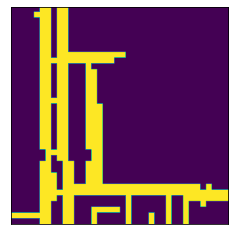

In [40]:
show_image(batches1[0][0])

In [41]:
model_name = 'ensemble_model'

In [42]:
submission_filename = model_name + '_predictions.csv'
pred_counter = 0

In [43]:
with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        
        for mask, name in s:
            predicted_mask = np.asarray(mask.cpu().squeeze())

            ids = mask_to_submission_strings(predicted_mask, name)
            f.writelines('{}\n'.format('\n'.join(ids)))

            pred_counter += 1
pred_counter

94